In [1]:
import numpy as np
from dataset.mnist import load_mnist
from collections import OrderedDict

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

In [3]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    def backward(self, dout = 1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        
        return dx

In [4]:
# 2차원 데이터 처리르르 위한 softmax
def softmax(x):
    x = x - np.max(x, axis = -1, keepdims = True)
    return np.exp(x) / np.sum(np.exp(x), axis = -1, keepdims = True)

# 미니 배치용 CEE
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y)) / batch_size

In [5]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        
        self.dw = None
        self.db = None
        
    def forward(self, x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
        
        out = np.dot(self.x, self.W) + self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dw = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis = 0)
        
        dx = dx.reshape(*self.original_x_shape)
        return dx

In [6]:
class ThreeLayerNet:
    
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size1)
        self.params['b1'] = np.zeros(hidden_size1)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size1, hidden_size2)
        self.params['b2'] = np.zeros(hidden_size2)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size2, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        #계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine (self.params['W1'], self.params['b1'])
        self.layers['Sigmoid1'] = Sigmoid()
        self.layers['Affine2'] = Affine (self.params['W2'], self.params['b2'])
        self.layers['Sigmoid2'] = Sigmoid()
        self.layers['Affine3'] = Affine (self.params['W3'], self.params['b3'])
        
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy (self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        if t.ndim != 1 :
            t = np.argmax(t, axis = 1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['W3'])

        return grads

    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()

        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dw, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dw, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dw, self.layers['Affine3'].db

        return grads

In [7]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = ThreeLayerNet(input_size=784, hidden_size1=50, hidden_size2=100, output_size=10)

iters_num = 50000
train_size = x_train.shape[0]
batch_size = 50
learning_rate = 0.1

train_loss_list = []
train_loss_list2 = []
train_acc_list = []
test_acc_list = []
epoch = 0

iter_per_epoch = max(train_size / batch_size, 1)

In [8]:
for i in range(iters_num):
    # 미니배치 획득
    batch_mask =np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 수치 미분을 통한 기울기 계산
    # graｄ　=　ｎｅｔｗｏｒｋ．ｎｕｍｅｒｉｃａｌ＿ｇｒａｄｉｅｎｔ（ｘ＿ｂａｔｃｈ，　ｔ＿ｂａｔｃｈ）
    
    # 오차 역전파를 통한 기울기 계산
    grad = network.gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        epoch += 1
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        train_loss_list2.append(loss)
        
        print("Epoch : ", epoch, "=> train 정확도 : ", round(train_acc * 100, 2),
              "% / test 정확도 : ", round(test_acc * 100, 2),
              "% / loss 정확도 : ", round(loss, 4))
        
print('종료')

Epoch :  1 => train 정확도 :  11.24 % / test 정확도 :  11.35 % / loss 정확도 :  2.2639
Epoch :  2 => train 정확도 :  9.74 % / test 정확도 :  9.82 % / loss 정확도 :  2.2613
Epoch :  3 => train 정확도 :  9.92 % / test 정확도 :  10.09 % / loss 정확도 :  2.3047
Epoch :  4 => train 정확도 :  27.03 % / test 정확도 :  27.57 % / loss 정확도 :  2.1112
Epoch :  5 => train 정확도 :  47.43 % / test 정확도 :  46.83 % / loss 정확도 :  1.3324
Epoch :  6 => train 정확도 :  69.23 % / test 정확도 :  69.92 % / loss 정확도 :  0.8661
Epoch :  7 => train 정확도 :  82.35 % / test 정확도 :  82.37 % / loss 정확도 :  0.7177
Epoch :  8 => train 정확도 :  87.3 % / test 정확도 :  87.67 % / loss 정확도 :  0.7132
Epoch :  9 => train 정확도 :  89.82 % / test 정확도 :  90.03 % / loss 정확도 :  0.5852
Epoch :  10 => train 정확도 :  91.46 % / test 정확도 :  91.61 % / loss 정확도 :  0.2287
Epoch :  11 => train 정확도 :  92.69 % / test 정확도 :  92.6 % / loss 정확도 :  0.3142
Epoch :  12 => train 정확도 :  93.36 % / test 정확도 :  93.29 % / loss 정확도 :  0.1825
Epoch :  13 => train 정확도 :  94.06 % / test 정확도 :  93.82 % / loss 정

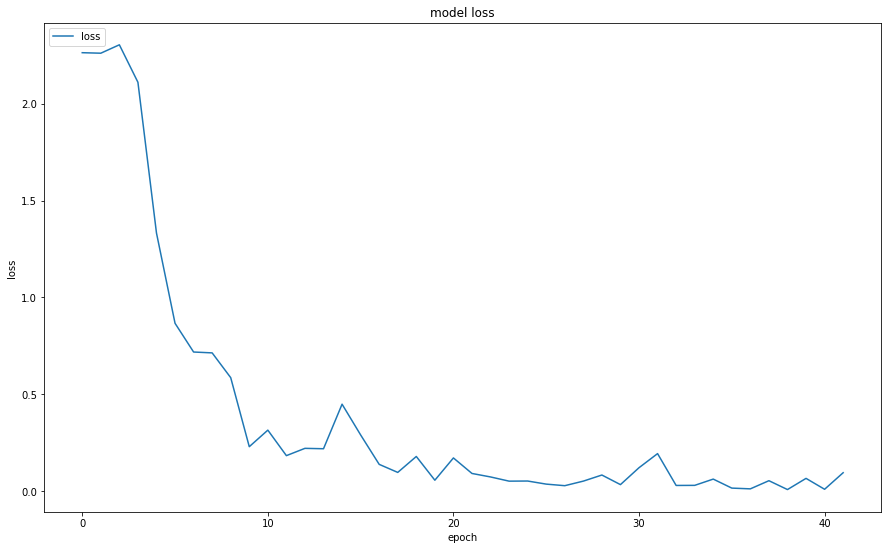

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 9))
plt.plot(train_loss_list2)
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["loss"], loc = "upper left")
plt.show()

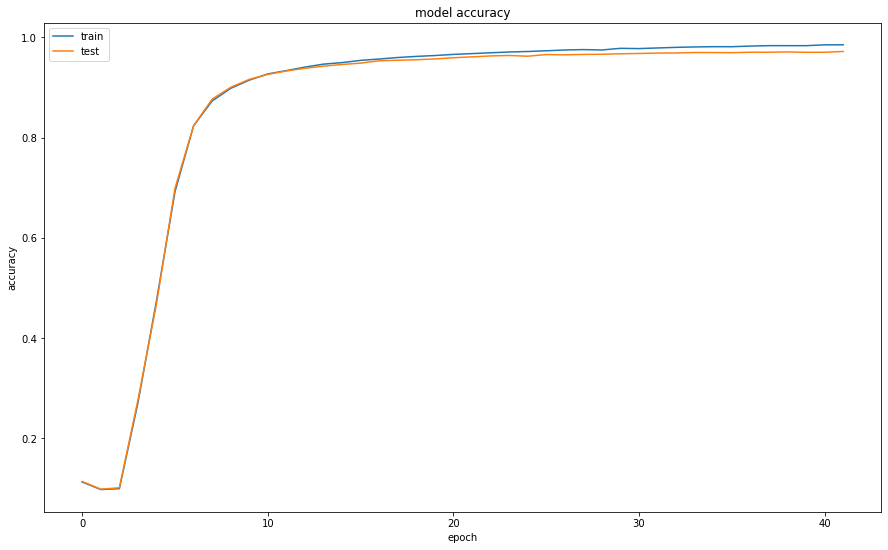

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 9))
plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc = "upper left")
plt.show()